Importing libraries

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

In [ ]:
!pip install pydot
!pip install plot-model

# Standard Classification vs One Shot Learning

## Standard Classification

The input image is fed through a number of layers in the case of standard classification, and at the output, it produces a probability distribution over all the classes (typically using a Softmax). 
Each input image constructs n probabilities, each representing the likelihood that the image belongs to one of the 10 classes—for instance, apple, banana, orange, or blueberry. 
Here, two crucial things need to be noted. 
First, for each class/fruit, we need a lot of photographs during the training process.
Second, we cannot expect to test the network on any other class, for instance "avocado" if it has only been trained on the 10 classes of photos not including. We must first gather a large number of avocado photographs before retraining the model if we want it to classify zebra avocado as well. In our application, automotiva part, we don't have enough data for every class, and there are a lot of classes that are constantly changing. Data gathering and regular retraining are therefore prohibitively expensive. A one-shot classification, on the other hand, can have even one training example for each class. That's why it is calles one-shot

## One shot classification

In [22]:
import glob
import os

def listdir_nohidden(path):
    """The following function get items i the folder
    add them to the relative path,"""
    return glob.glob(os.path.join(path, '*'))

We compute the similarity scores between photographs of various classes rather than utilizing enormous amounts of data for each class. Two photos, either from the same class or another, will constitute the input to this network. The result will be a number4 between 0 and 1, with 1 signifying that the two photos belong to the same class and 0 signifying that they do not.

In [44]:
base_dir = r'/Users/vazgen/Desktop/capstone/Dev/datasets/fruit/fruits-360/360/Training'
train_test_split = 0.8 ##80 percent of the data will be in training split
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = listdir_nohidden(base_dir)
print( len(folder_list), "fruits found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = listdir_nohidden(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape) 

131 fruits found in the dataset
X, Y shape (1310, 100, 100, 3) (1310,) (131, 10)


- Line 1: Including the base directory of the dataset
 -Line 2: Indicate the percentage that is going to be used for training. The rest will be used for testing
- Line 3: Since Fruits 360 is a dataset for Image classification, It has a lot of images per category. But for our experiment, a small portion is enough.
- Line 6: Get the list of directories from the folder. Each folder contains of particular image
- Line 10–13: Declare three empty lists to record X(images), y(labels), cat_list(To record the category of each image)
- Line 16–24: Iterate over the class folders and select ten images from each of the class, convert them to RGB format and append them to a list. keep a record of the class of the image in cat_list[] for further reference
- Line 26–28: Convert all the list to NumPy arrays. As any image will range from 0–255, divide the array x by 255 - for simplification

In [45]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)


104 classes for training and 27  classes for testing
X&Y shape of training data : (1040, 100, 100, 3) and (1040,) (104, 10)
X&Y shape of testing data : (270, 100, 100, 3) and (270,) (27, 10)


- Line 1: Calculate the number of classes that will be used for training by multiplying with the train_test_split
- Line 2: Subtract train_size from the total classes available to get the test_size
- Line 4: Multiply train_size with the number of files in each class to get the total number of training files
- Line 7–15: Use the value calculated before to subset X, Y and cat_list

# Generating Batch

In this section we generate batches for training. An X and Y should be present in the batch files. If the batch size is 64 and the picture size is (100, 100, 3), then the size of X would be a list of size 64 and each element in the list would be of size (100, 100, 3).

Given that we had two inputs, there would be a list (let's call it "A") of size 64 and each element would have a list (let's call it "B") of length 2 and a size of 64 in "A." (100, 100, 3). We'll create a batch for training so that for half the input pairings, B[0] and B[1]

In [46]:
def get_batch(batch_size=64):
    """Generating batches"""
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

- Line 3–7: Store the values of x_train, cat_train and the start and end size of training size in a temporary variables
- Line 9–11: Assigning half of the batch_size of Y as 0 and others as 1
- Line 13: Generate a random list of classes from the training category list to be used. Also, append two arrays of image_size*batch_size
- Line 17–25: For each iteration, In case of batch_x[0] select an image from the category specified in the class list. For batch_x[1] select an image from the same category if y[i] is 0, else select batch_x[1] from any other category except for the same one

# Architecture

A CNN model consists of a number of convolutional and pooling layers, several dense layers, and an output layer that most often has a softmax function. Here, the softmax layer is in charge of supplying a range of probabilities for each class while the convolutional layers are in charge of extracting features from the picture. The class of the image with the highest probability value is then selected.For activation functions we use sigmoid

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $<br>
$Sigmoid: \sigma(z) = \frac{1} {1 + e^{-z}} $

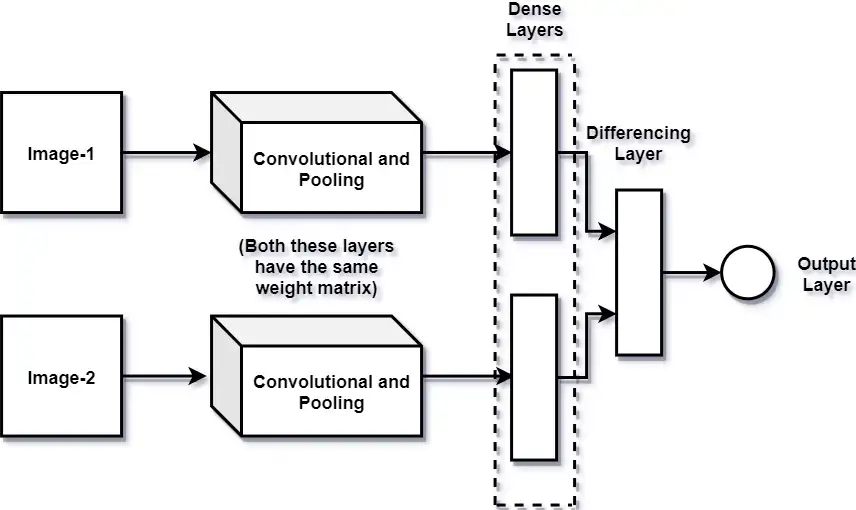

In [55]:
from IPython.display import Image
Image("fig1.png")

/Users/vazgen/miniforge3/envs/DLP/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


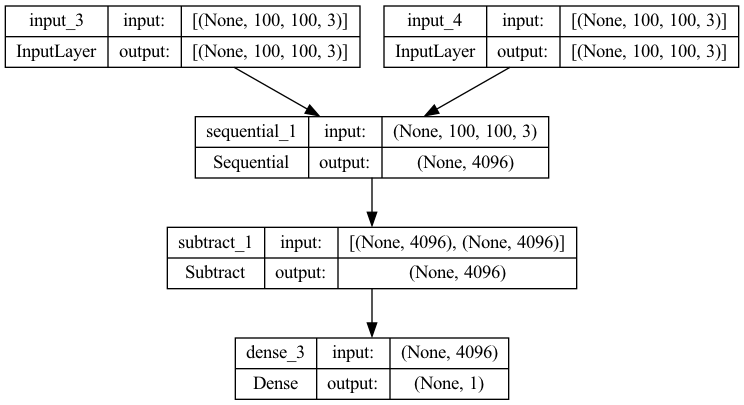

In [26]:
##see the comments below
#Building a sequential model
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer= Adam(learning_rate=0.0001)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

- Line 1: Declare the shape of the input image.
- Line 2: Declare two inputs with the shape of the image.
- Line 6–7: Declare parameters for initializing weight and bias of the network. The values are chosen as described in the paper.
- Line 9–20: Declare a Sequential model with 4 convolutional layers and max-pooling layers. Use a flattening layer at last followed by a dense layer.
- Line 22–23: Pass both the inputs to the same model.
- Line 25–27: Subtract the dense layers from both the images and pass it through a single neuron with a sigmoid activation function.
- Line 29–30: Compile the model with loss as ‘binary_cross_entropy’ and ‘Adam’ optimizer.
- Line 32: The plot model function for siamese_net outputs the following.

# N-way one-shot Learning

We choose 'n' input pairs such that only one input pair belongs to the same category and the others are all from distinct ones. This is a procedure of confirming one-shot learning. 
In the case of a nine-way one-shot validation where each input to the network requires two photos, x[0] is constant across all nine pairings, x[1] only falls under the same category as x[0] across one out of every nine pairs, and x[1] is different across the other eight. 
If all nine pairs are provided to the model, it is anticipated that the pair that falls under the same category would have the pair's lowest value. 
We consider it a successful forecast in this scenario.
The number of steps in validation is indicated by the input parameter n val. 
The number of ways for each stage of validation is indicated by the term "n way." 
Keep in mind that x[0] remains constant during all validation steps.


In [38]:
def nway_one_shot(model, n_way, n_val):
    """Perform n_way classification"""
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
#                 print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
#                 print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

- Line 3–7: Store x_val, cat_test in a temporary variable
- Line 9: This is the same as Line 13 in the batch generation, except we create a batch of random categories from the test set
- Line 11–24: For each validation step, we iterate through the n_way, take the corresponding category list from class_list, pick an image from that category and store it in x[0]. For x[1] select an image from the same category if it is the first iteration, and select from a different category for others. This inner loop is almost the same as batch_generation() method discussed above.
- Line 26–31: For each of the validation step, predict the output using the model and check if result[0] has the minimum value compared to others. Note that the result array will be a list of size n_way. If yes add 1 to n_correct. Repeat the same for all other validation steps.
- Line 32: Calculate the accuracy using n_correct and the number of validation steps.

In [50]:
#seeing available GPUs
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
tf.debugging.set_log_device_placement(True)

# Training a model

In [42]:
with tf.device('/GPU'):#apple (n diffirent fruits) 20 (1,1)(1,0)(1,0)(1,0)
    epochs = 300
    n_way = 20
    n_val = 100
    batch_size = 128
    
    loss_list=[]
    accuracy_list=[]
    for epoch in range(1,epochs):
        batch_x, batch_y = get_batch(batch_size)
        loss = siamese_net.train_on_batch(batch_x, batch_y)
        loss_list.append((epoch,loss))
        if epoch%250 == 0:
            print("=============================================")
            accuracy = nway_one_shot(model, n_way, n_val)
            accuracy_list.append((epoch, accuracy))
            print('Epoch:', epoch, ', Loss:',loss)
            print('Accuracy as of', epoch, 'epochs:', accuracy)
            print("=============================================")
            if(accuracy>99):
                print("Achieved more than 90% Accuracy")

129 0 1299 1295
129 1 1299 1218
129 2 1299 793
129 3 1299 784
129 4 1299 297
129 5 1299 602
129 6 1299 1076
129 7 1299 194
129 8 1299 1138
129 9 1299 1234
129 10 1299 821
129 11 1299 10
129 12 1299 180
129 13 1299 587
129 14 1299 785
129 15 1299 577
129 16 1299 599
129 17 1299 473
129 18 1299 172
129 19 1299 421
1/1 [==============================] - 0s 13ms/step
104 0 1047 1046
104 1 1047 444
104 2 1047 302
104 3 1047 1269
104 4 1047 1186
104 5 1047 32
104 6 1047 808
104 7 1047 930
104 8 1047 969
104 9 1047 1130
104 10 1047 394
104 11 1047 919
104 12 1047 330
104 13 1047 1225
104 14 1047 1270
104 15 1047 1125
104 16 1047 272
104 17 1047 1261
104 18 1047 866
104 19 1047 553
1/1 [==============================] - 0s 14ms/step
121 0 1215 1214
121 1 1215 19
121 2 1215 1294
121 3 1215 1291
121 4 1215 738
121 5 1215 463
121 6 1215 1208
121 7 1215 1172
121 8 1215 428
121 9 1215 128
121 10 1215 861
121 11 1215 678
121 12 1215 215
121 13 1215 1303
121 14 1215 635
121 15 1215 647
121 16 1215 39

1/1 [==============================] - 0s 13ms/step
104 0 1042 1044
104 1 1042 137
104 2 1042 504
104 3 1042 1286
104 4 1042 1132
104 5 1042 969
104 6 1042 1051
104 7 1042 850
104 8 1042 1098
104 9 1042 492
104 10 1042 1187
104 11 1042 314
104 12 1042 244
104 13 1042 959
104 14 1042 450
104 15 1042 842
104 16 1042 160
104 17 1042 459
104 18 1042 601
104 19 1042 582
1/1 [==============================] - 0s 13ms/step
115 0 1155 1151
115 1 1155 869
115 2 1155 883
115 3 1155 614
115 4 1155 96
115 5 1155 687
115 6 1155 1099
115 7 1155 1117
115 8 1155 60
115 9 1155 950
115 10 1155 913
115 11 1155 372
115 12 1155 76
115 13 1155 502
115 14 1155 532
115 15 1155 454
115 16 1155 819
115 17 1155 817
115 18 1155 1140
115 19 1155 222
1/1 [==============================] - 0s 13ms/step
108 0 1086 1081
108 1 1086 868
108 2 1086 454
108 3 1086 1216
108 4 1086 123
108 5 1086 100
108 6 1086 350
108 7 1086 8
108 8 1086 495
108 9 1086 49
108 10 1086 274
108 11 1086 1295
108 12 1086 1300
108 13 1086 806
10

1/1 [==============================] - 0s 13ms/step
115 0 1158 1152
115 1 1158 1117
115 2 1158 765
115 3 1158 1202
115 4 1158 273
115 5 1158 853
115 6 1158 1002
115 7 1158 516
115 8 1158 470
115 9 1158 681
115 10 1158 1109
115 11 1158 1193
115 12 1158 145
115 13 1158 1044
115 14 1158 978
115 15 1158 1020
115 16 1158 841
115 17 1158 76
115 18 1158 540
115 19 1158 172
1/1 [==============================] - 0s 13ms/step
117 0 1175 1179
117 1 1175 1205
117 2 1175 817
117 3 1175 112
117 4 1175 3
117 5 1175 1033
117 6 1175 232
117 7 1175 583
117 8 1175 56
117 9 1175 282
117 10 1175 852
117 11 1175 1214
117 12 1175 403
117 13 1175 1057
117 14 1175 233
117 15 1175 1153
117 16 1175 821
117 17 1175 776
117 18 1175 482
117 19 1175 407
1/1 [==============================] - 0s 13ms/step
97 0 976 974
97 1 976 108
97 2 976 980
97 3 976 246
97 4 976 1248
97 5 976 616
97 6 976 1040
97 7 976 292
97 8 976 27
97 9 976 225
97 10 976 235
97 11 976 428
97 12 976 405
97 13 976 231
97 14 976 535
97 15 976 250

1/1 [==============================] - 0s 12ms/step
114 0 1147 1148
114 1 1147 1094
114 2 1147 26
114 3 1147 1163
114 4 1147 376
114 5 1147 788
114 6 1147 1112
114 7 1147 667
114 8 1147 435
114 9 1147 71
114 10 1147 1227
114 11 1147 695
114 12 1147 759
114 13 1147 57
114 14 1147 310
114 15 1147 74
114 16 1147 426
114 17 1147 1171
114 18 1147 764
114 19 1147 884
1/1 [==============================] - 0s 13ms/step
111 0 1119 1112
111 1 1119 48
111 2 1119 155
111 3 1119 506
111 4 1119 173
111 5 1119 944
111 6 1119 409
111 7 1119 939
111 8 1119 717
111 9 1119 1275
111 10 1119 828
111 11 1119 1285
111 12 1119 698
111 13 1119 1041
111 14 1119 418
111 15 1119 215
111 16 1119 291
111 17 1119 1249
111 18 1119 1269
111 19 1119 1299
1/1 [==============================] - 0s 12ms/step
110 0 1108 1105
110 1 1108 1166
110 2 1108 997
110 3 1108 1197
110 4 1108 163
110 5 1108 239
110 6 1108 55
110 7 1108 632
110 8 1108 220
110 9 1108 426
110 10 1108 356
110 11 1108 953
110 12 1108 1129
110 13 1108 924

1/1 [==============================] - 0s 18ms/step
116 0 1168 1163
116 1 1168 685
116 2 1168 566
116 3 1168 107
116 4 1168 1101
116 5 1168 1179
116 6 1168 1309
116 7 1168 696
116 8 1168 425
116 9 1168 1132
116 10 1168 762
116 11 1168 675
116 12 1168 994
116 13 1168 308
116 14 1168 49
116 15 1168 777
116 16 1168 292
116 17 1168 1173
116 18 1168 829
116 19 1168 1102
1/1 [==============================] - 0s 15ms/step
100 0 1002 1008
100 1 1002 1186
100 2 1002 1215
100 3 1002 1230
100 4 1002 391
100 5 1002 367
100 6 1002 40
100 7 1002 1220
100 8 1002 269
100 9 1002 1147
100 10 1002 266
100 11 1002 493
100 12 1002 330
100 13 1002 79
100 14 1002 334
100 15 1002 745
100 16 1002 661
100 17 1002 48
100 18 1002 44
100 19 1002 186
1/1 [==============================] - 0s 13ms/step
127 0 1271 1273
127 1 1271 1226
127 2 1271 74
127 3 1271 1129
127 4 1271 104
127 5 1271 463
127 6 1271 759
127 7 1271 27
127 8 1271 714
127 9 1271 871
127 10 1271 439
127 11 1271 657
127 12 1271 879
127 13 1271 392
1

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
with tf.device('/GPU'):
    epochs = 300
    n_way = 10
    n_val = 100
    batch_size = 128
    
    loss_list=[]
    accuracy_list=[]
    for epoch in range(1,epochs):
        batch_x, batch_y = get_batch(batch_size)
        loss = siamese_net.train_on_batch(batch_x, batch_y)
        loss_list.append((epoch,loss))
        if epoch%250 == 0:
            print("=============================================")
            accuracy = nway_one_shot(model, n_way, n_val)
            accuracy_list.append((epoch, accuracy))
            print('Epoch:', epoch, ', Loss:',loss)
            print('Accuracy as of', epoch, 'epochs:', accuracy)
            print("=============================================")
            if(accuracy>99):
                print("Achieved more than 90% Accuracy")

1/1 [==============================] - 0s 12ms/step
100 correctly classified among 100
Epoch: 250 , Loss: 0.6931470632553101
Accuracy as of 250 epochs: 100.0
Achieved more than 90% Accuracy
